### Libraries and the Dataset

**About the data**

The *Times Higher Education (THE)* university rankings dataset from 2011 to 2016.

A world rank is designated and scores assigned between 0 and 100 for:

* Teaching (teaching/the learning environment)
* International Outlook (international/staff, students and research)
* Research (research/volume, income and reputation)
* Citations (citations/research influence)
* Industry Income (income/knowledge transfer, value not available for all)

The weight of the above factors in calculating the total score:

Teaching: 30%;
International Outlook 7.5%;
Research: 30%;
Citations: 30%;
Industry Income: 2.5%;

      total_score = 0.3*teaching + 0.075*international + 0.3*research + 0.3*citations + 0.025*income



In [ ]:
# Import necessary libraries
import math
import copy
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pingouin
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

In [ ]:
# Load the dataset
path = "/content/uni_rankings_dataset.csv"
data = pd.read_csv(path)

# View feature names and the top 10 instances
data.head(10)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,"15,596",7.8,22%,42 : 58,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,-,94.2,"7,929",8.4,27%,45 : 55,2011
5,6,University of Cambridge,United Kingdom,90.5,77.7,94.1,94.0,57.0,91.2,"18,812",11.8,34%,46 : 54,2011
6,6,University of Oxford,United Kingdom,88.2,77.2,93.9,95.1,73.5,91.2,"19,919",11.6,34%,46 : 54,2011
7,8,"University of California, Berkeley",United States of America,84.2,39.6,99.3,97.8,-,91.1,"36,186",16.4,15%,50 : 50,2011
8,9,Imperial College London,United Kingdom,89.2,90.0,94.5,88.3,92.9,90.6,"15,060",11.7,51%,37 : 63,2011
9,10,Yale University,United States of America,92.1,59.2,89.7,91.5,-,89.5,"11,751",4.4,20%,50 : 50,2011


### Exploratory Data Analysis


#### Feature Analysis

In [ ]:
# (instances, features)
print("Dataframe shape: ", data.shape, "\n")
print(data.info())

Dataframe shape:  (2603, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   world_rank              2603 non-null   object 
 1   university_name         2603 non-null   object 
 2   country                 2603 non-null   object 
 3   teaching                2603 non-null   float64
 4   international           2603 non-null   object 
 5   research                2603 non-null   float64
 6   citations               2603 non-null   float64
 7   income                  2603 non-null   object 
 8   total_score             2603 non-null   object 
 9   num_students            2544 non-null   object 
 10  student_staff_ratio     2544 non-null   float64
 11  international_students  2536 non-null   object 
 12  female_male_ratio       2370 non-null   object 
 13  year                    2603 non-null   int64  
dtypes: float6

1. `world_rank` : World rank for the university. Contains rank ranges and equal ranks (eg. =94 and 201-250)
2. `university_name` : Name of the university
3. `country` : Country of each university
4. `teaching` : University score for teaching (the learning environment)
5. `international` : University score for international outlook (students, staff, reasearch)
6. `research` : University score for research (volume, income and reputation)
7. `citations` : University score for citations (research influence)
8. `income` : University score for industry income (knowledge transfer)
9. `total_score` : Total score for university, used to determine rank
10. `num_students` : Number of students at the university
11. `student_staff_ratio` : Ratio of students to staff at the university
12. `international_students` : Percentage of students of international origin
13. `female_male_ratio` : Ratio of female students to male students in the university
14. `year` : Year of publishing rankings

#### String Processing

In [ ]:
# Data contains '-' values, assign as NaN
data.replace('-', np.NaN, inplace=True)

**Process categorical variable values**

In [ ]:
# Check for inconsistent capitalization
print(*set(data.country.values), sep=' ')

Chile Belgium Lebanon Thailand Egypt Australia Argentina Unted Kingdom Denmark Romania Germany Israel United Kingdom Japan Cyprus Spain Turkey United States of America Hong Kong Luxembourg Belarus Nigeria Serbia Kenya Slovakia Finland Iceland Macau Uganda Ghana Slovenia Iran Lithuania New Zealand China Norway Unisted States of America Hungary Bangladesh Latvia Jordan Russian Federation India South Korea Saudi Arabia Switzerland Portugal South Africa Qatar Ukraine Morocco Estonia Italy Mexico United Arab Emirates Colombia Sweden Pakistan Brazil Greece Poland Taiwan Republic of Ireland Indonesia Malaysia France Oman Canada Austria Czech Republic Singapore Netherlands


No inconsistent capitalization found

In [ ]:
# Process world_rank
data.world_rank.value_counts().keys()

Index(['301-350', '601-800', '351-400', '276-300', '201-225', '501-600',
       '226-250', '401-500', '251-275', '201-250',
       ...
       '=138', '=82', '=99', '=123', '=39', '=65', '=47', '=176', '133',
       '179'],
      dtype='object', length=250)

In [ ]:
# Observe year keys and number of instances each
data.year.value_counts()

2016    800
2012    402
2015    401
2013    400
2014    400
2011    200
Name: year, dtype: int64

**Process numeric variables values**

In [ ]:
# Process num_students to remove commas
print("Before processing: ")
print(*data.num_students.values[:20], sep=", ")
print("\n")

# Replace commas with empty string 
data.num_students = [i.replace(',', '') if isinstance(i, str) else i for i in data.num_students.values]
# Convert from str to float, can be changed to int after data cleaning
data.num_students = [float(i) for i in data.num_students.values]

print("After processing 'num_students': ")
print(*data.num_students.values[:20], sep=", ")

Before processing: 
20,152, 2,243, 11,074, 15,596, 7,929, 18,812, 19,919, 36,186, 15,060, 11,751, 38,206, 14,221, 15,128, 21,424, 18,178, 41,786, 66,198, 25,055, 20,376, 11,885


After processing 'num_students': 
20152.0, 2243.0, 11074.0, 15596.0, 7929.0, 18812.0, 19919.0, 36186.0, 15060.0, 11751.0, 38206.0, 14221.0, 15128.0, 21424.0, 18178.0, 41786.0, 66198.0, 25055.0, 20376.0, 11885.0


In [ ]:
# Process international_students
print("Before processing: ")
print(*data.international_students.values[:30], sep=", ")
print("\n")

# Remove percentage symbols from the 'international_students' feature
data.international_students = [i[ : -1] if isinstance(i, str) else i for i in data.international_students.values]
# Convert from str to float
data.international_students = [float(i) for i in data.international_students.values]

print("After processing 'international_students': ")
print(*data.international_students.values[:30], sep=", ")

Before processing: 
25%, 27%, 33%, 22%, 27%, 34%, 34%, 15%, 51%, 20%, 15%, 21%, 23%, 19%, 37%, 16%, 15%, 28%, 20%, 35%, 38%, 46%, 13%, 17%, 15%, 10%, 26%, 4%, 11%, 25%


After processing 'international_students': 
25.0, 27.0, 33.0, 22.0, 27.0, 34.0, 34.0, 15.0, 51.0, 20.0, 15.0, 21.0, 23.0, 19.0, 37.0, 16.0, 15.0, 28.0, 20.0, 35.0, 38.0, 46.0, 13.0, 17.0, 15.0, 10.0, 26.0, 4.0, 11.0, 25.0


In [ ]:
# Process female_male_ratio 
print("Before processing: ")
print(*data.female_male_ratio.values[ : 20], sep=", ")
print("\n")

# Rename column name to female_ratio
data.rename(columns={'female_male_ratio' : 'female_ratio'}, inplace=True)

# Convert ratio to decimal flaoting values
data.female_ratio = [('0.'+i[ : 2]) if isinstance(i, str) else i for i in data.female_ratio]
data.female_ratio = [float(i) for i in data.female_ratio.values]

print("After processing 'female_ratio': ")
print(*data.female_ratio.values[ : 20], sep=", ")

Before processing: 
nan, 33 : 67, 37 : 63, 42 : 58, 45 : 55, 46 : 54, 46 : 54, 50 : 50, 37 : 63, 50 : 50, 52 : 48, 42 : 58, 50 : 50, 48 : 52, 31 : 69, 48 : 52, nan, nan, 51 : 49, 39 : 61


After processing 'female_ratio': 
nan, 0.33, 0.37, 0.42, 0.45, 0.46, 0.46, 0.5, 0.37, 0.5, 0.52, 0.42, 0.5, 0.48, 0.31, 0.48, nan, nan, 0.51, 0.39


This implies that the dataset consists of rankings from the years 2011-2016

**Convert variable values to appropriate data types**

In [ ]:
def check_col_types(df):
  
  """Prints data types of all 
  values of every feature in a
  dataframe""" 
  for col in df.columns:
    types = set()
    for val in df[col].values:
      types.add(type(val))
    print(col, ':', *types)

check_col_types(data)

world_rank : <class 'str'>
university_name : <class 'str'>
country : <class 'str'>
teaching : <class 'numpy.float64'>
international : <class 'float'> <class 'str'>
research : <class 'numpy.float64'>
citations : <class 'numpy.float64'>
income : <class 'float'> <class 'str'>
total_score : <class 'float'> <class 'str'>
num_students : <class 'numpy.float64'>
student_staff_ratio : <class 'numpy.float64'>
international_students : <class 'numpy.float64'>
female_ratio : <class 'numpy.float64'>
year : <class 'numpy.int64'>


In [ ]:
# Check what values are of type str
print('international: ', [i for i in data.international.values[:20] if isinstance(i, str)])
print('income:', [i for i in data.income.values[:20] if isinstance(i, str)])
print('total_score:', [i for i in data.total_score.values[:20] if isinstance(i, str)])

# Convert all str values to type float or int
data.international = [float(i) for i in data.international.values]
data.income = [float(i) for i in data.income.values]
data.total_score = [float(i) for i in data.total_score.values]

international:  ['72.4', '54.6', '82.3', '29.5', '70.3', '77.7', '77.2', '39.6', '90.0', '59.2', '48.1', '62.8', '58.5', '62.4', '93.7', '53.3', '90.9', '32.9', '39.1']
income: ['34.5', '83.7', '87.5', '64.3', '57.0', '73.5', '92.9', '100.0', '34.7', '59.6', '43.7', '53.7']
total_score: ['96.1', '96.0', '95.6', '94.3', '94.2', '91.2', '91.2', '91.1', '90.6', '89.5', '87.7', '86.9', '86.4', '83.9', '83.4', '83.4', '82.0', '81.0', '79.5', '79.3']


In [ ]:
# Check if data types are appropriate after processing
check_col_types(data)

world_rank : <class 'str'>
university_name : <class 'str'>
country : <class 'str'>
teaching : <class 'numpy.float64'>
international : <class 'numpy.float64'>
research : <class 'numpy.float64'>
citations : <class 'numpy.float64'>
income : <class 'numpy.float64'>
total_score : <class 'numpy.float64'>
num_students : <class 'numpy.float64'>
student_staff_ratio : <class 'numpy.float64'>
international_students : <class 'numpy.float64'>
female_ratio : <class 'numpy.float64'>
year : <class 'numpy.int64'>


In [ ]:
data.head(6)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,20152.0,8.9,25.0,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,2243.0,6.9,27.0,0.33,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,11074.0,9.0,33.0,0.37,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,15596.0,7.8,22.0,0.42,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,NaN,94.2,7929.0,8.4,27.0,0.45,2011
5,6,University of Cambridge,United Kingdom,90.5,77.7,94.1,94.0,57.0,91.2,18812.0,11.8,34.0,0.46,2011


####Handling Missing Values

In [ ]:
# Separate categorical and numerical variables
categorical_vars = ["world_rank", "university_name", "country", "year"]
numerical_vars = ["teaching", "international", "research", "citations", "income", "total_score", "num_students", "student_staff_ratio", "international_students", "female_ratio"] 

# NaN values in categorical variables
print("Missing categorical values :")
print([data[i].isnull().sum() for i in categorical_vars])

# NaN values in numerical variables
print("Missing numerical values :")
missing_cat = [(i, data[i].isnull().sum()) for i in numerical_vars]
print(*missing_cat, sep='\n')
missing_vars = [var for (var, count) in missing_cat if count!=0]
print("\nVariables with missing values: ", *missing_vars)

Missing categorical values :
[0, 0, 0, 0]
Missing numerical values :
('teaching', 0)
('international', 9)
('research', 0)
('citations', 0)
('income', 218)
('total_score', 1402)
('num_students', 59)
('student_staff_ratio', 59)
('international_students', 67)
('female_ratio', 236)

Variables with missing values:  international income total_score num_students student_staff_ratio international_students female_ratio


Check for outliers in each variable to determine the best central tendancy measure as replacement for missing values

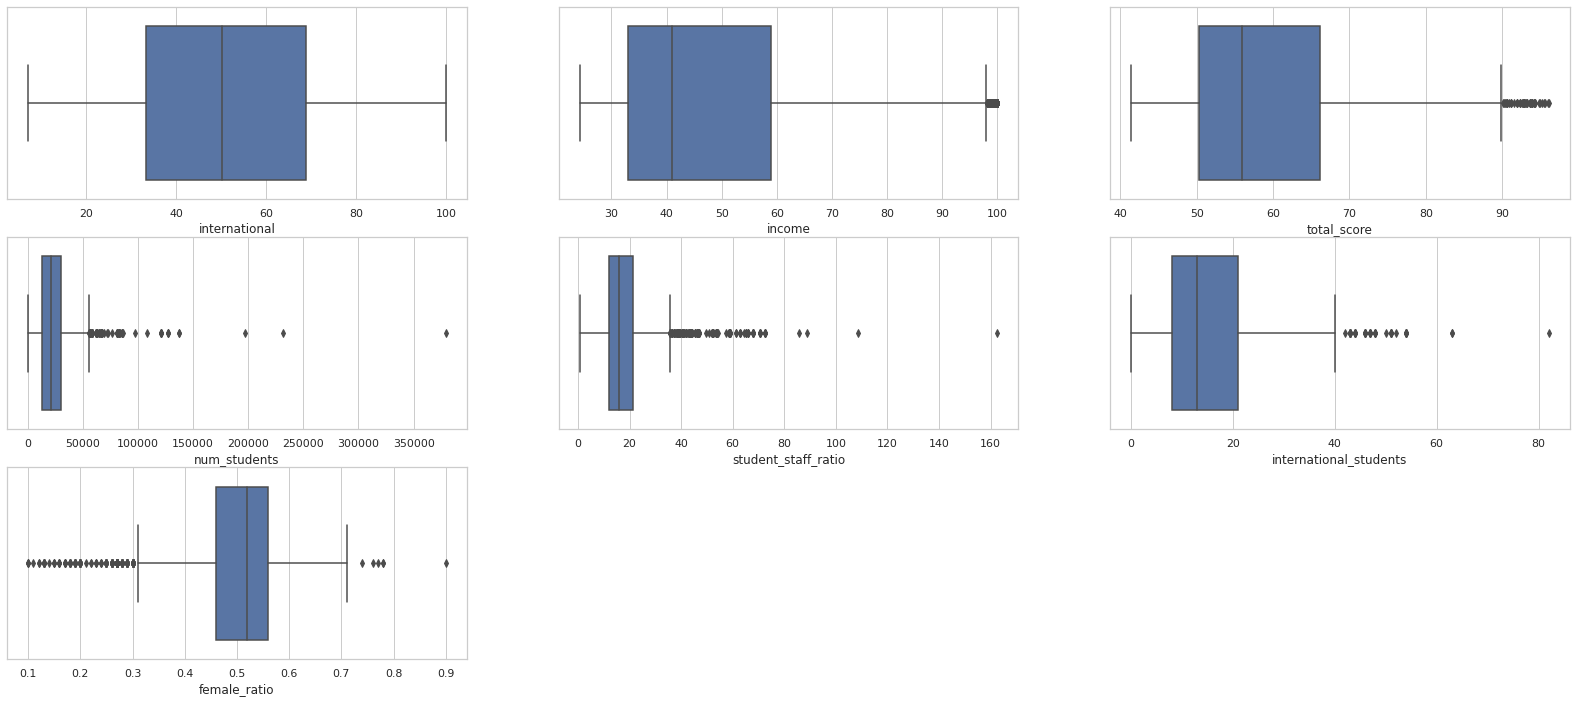

In [ ]:
# Boxplots for numerical variables
sns.set_theme(style="whitegrid")
plt.figure(figsize=(28, 12))

for i, col in enumerate(missing_vars, 1):
  plt.subplot(3, 3, i)
  ax = sns.boxplot(x=data[col])

`international` has only 9 missing values and has a relatively symmetric distribution about the mean. Therefore, we decide to fill in missing values with the previous value to maintain the shape of the distribution.

In [ ]:
# Fill NaN in international with previous values
data['international'] = data['international'].fillna(method='ffill').fillna(method='bfill')

`num_students`,  `student_staff_ratio` and `international_students` have around 60 missing, and higly right-skewed distributions. We therefore decide to replace NaN with the median of each.

In [ ]:
# Replace missing with the median value
data.num_students.fillna(data.num_students.median(), inplace=True)
data.student_staff_ratio.fillna(data.student_staff_ratio.median(), inplace=True)
data.international_students.fillna(data.international_students.median(), inplace=True)

# Convert float to int now that NaN values are removed
data.num_students = [int(i) for i in data.num_students]

Both `female_ratio` and `income` have around 200 missing values. That is nearly 10% of all the instances, and the distribution is still skewed with huge outliers. Since the dataframe is ordered according to rank, we decide to impute the missing score values with the previous or next values in the feature column.

In [ ]:
# Replace missing values with neighbouring values
data.female_ratio = data.female_ratio.fillna(method='ffill').fillna(method='bfill')
data.income = data.income.fillna(method='ffill').fillna(method='bfill')

Over 54% of total_score is missing. Intuitively, `total_score` and `world_rank` establish the same correlation. Therefore, we decide to calculate the `total_score` values using the weightage method of designation of the overall score using the other scores in the dataset by the *THE*.

In [ ]:
# Replace total_score with transformation on the other score features, no resulting NaN values
data.total_score = 0.3*data.teaching + 0.075*data.international + 0.3*data.research + 0.3*data.citations + 0.025*data.income

In [ ]:
data.head()

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,95.4525,20152,8.9,25.0,0.33,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,94.8675,2243,6.9,27.0,0.33,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.0900,11074,9.0,33.0,0.37,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,92.5000,15596,7.8,22.0,0.42,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,64.3,92.7400,7929,8.4,27.0,0.45,2011


In [ ]:
check_col_types(data)
print("\n")
data.isnull().sum()

world_rank : <class 'str'>
university_name : <class 'str'>
country : <class 'str'>
teaching : <class 'numpy.float64'>
international : <class 'numpy.float64'>
research : <class 'numpy.float64'>
citations : <class 'numpy.float64'>
income : <class 'numpy.float64'>
total_score : <class 'numpy.float64'>
num_students : <class 'numpy.int64'>
student_staff_ratio : <class 'numpy.float64'>
international_students : <class 'numpy.float64'>
female_ratio : <class 'numpy.float64'>
year : <class 'numpy.int64'>




world_rank                0
university_name           0
country                   0
teaching                  0
international             0
research                  0
citations                 0
income                    0
total_score               0
num_students              0
student_staff_ratio       0
international_students    0
female_ratio              0
year                      0
dtype: int64

### Data Visualization

**Observing the difference in female populations in the UK and Germany throughout the years**

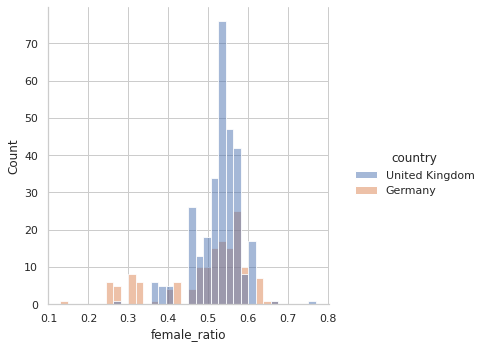

In [ ]:
# Plot a histogram with both countries' university female_ratios
data_female = data.loc[(data['country'] == 'Germany' ) | (data['country'] == 'United Kingdom')]
ax = sns.displot(data_female,
          x = "female_ratio",
          hue = 'country')

We can infer from the graph that Germnay has a supposedly slightly higher female population ratio in its universities. The data that is available for the UK is greater than that for the Germany. Both averages are higher than 0.5.

**Observing the frequency of universities featured in the top 10, grouped by country**

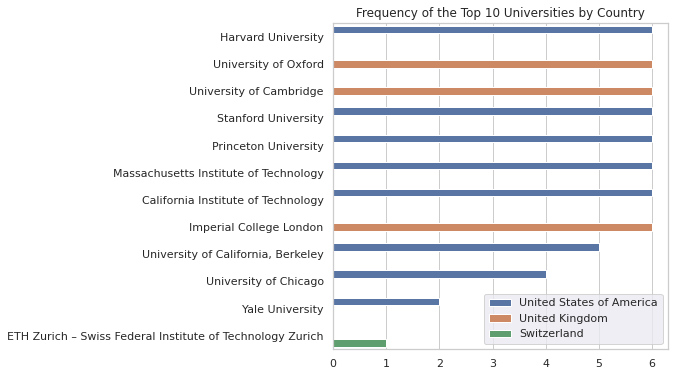

In [ ]:
# Create a dataframe of the top 10 universities
top_10 = [str(i) for i in range(11)]
featured_df = data.loc[data.world_rank.isin(top_10)].loc[:, ["university_name", "world_rank", "country"]]

# Get the frequency and countries of universities in the dataframe
frequency = featured_df.university_name.value_counts()
countries = list()
for i in frequency.index.to_list():
  countries.append(data.loc[data.university_name == i].country.iloc[0])

# Plot a bargraph of frequency against university by country
plt.figure(figsize=(6, 6))
plt.title("Frequency of the Top 10 Universities by Country")
sns.set_theme(style="darkgrid")
fig = sns.barplot(x = frequency.values,
                y = frequency.index.to_list(),
                hue = countries)

We can infer that 8 universities were featured in the top 10 all the years the rankings were listed. Most of the universities are from the US, 3 are from the UK and ETH Zurich is from Switzerland.

**Analyzing scores assigned to the top 10 universities in the year 2016**

In [ ]:
# Access the top 10 universities from the year 2016
data_top10_2016 = data.loc[data['year'] == 2016].head(10)
data_top10_2016_univs = []
for i in data_top10_2016['university_name']:
  data_top10_2016_univs.append(i)

# Create a tuple of titles for plots
myTitles = tuple(data_top10_2016_univs)

# Create subplots
fig = make_subplots(rows = 2,
                    cols = 5,
                    subplot_titles = myTitles,
                    specs = [[{'type':'polar'}, {'type':'polar'}, {'type':'polar'}, {'type':'polar'}, {'type':'polar'}],
                            [{'type':'polar'}, {'type':'polar'}, {'type':'polar'}, {'type':'polar'}, {'type':'polar'}]])
colCnt = 0
rowCnt = 1
modified_numeric_col = copy.deepcopy(numerical_vars)

# Remove num_students because of different scale
modified_numeric_col.remove("international_students")
modified_numeric_col.remove("num_students")
modified_numeric_col.remove("female_ratio")
modified_numeric_col.remove("student_staff_ratio")

# For the top 10 universities
for j in range(len(data_top10_2016_univs)): 
  # For each university
  data_particular_univ = data_top10_2016.iloc[j] 
  # Array for each year from which feature with lowest and highest score can be found out
  Rvals = []
  for k in modified_numeric_col:
    Rvals.append(data_particular_univ[k])
  minR = min(Rvals)
  maxR = max(Rvals)
  spy_df = pd.DataFrame(dict(x = [data_particular_univ[x] for x in modified_numeric_col],
                             theta = modified_numeric_col))
  colCnt = colCnt+1
  if(colCnt > 5):
    rowCnt = 2
    colCnt = 1
  fig.add_trace(go.Scatterpolar(r = [data_particular_univ[x] for x in modified_numeric_col],
                            theta = modified_numeric_col,
                            fill = 'toself'),
                row = rowCnt,
                col = colCnt)

# Update and show plots
fig.update_layout(height=1000, 
                width=4200, 
                title_text="Scores assigned to the top 10 universitites in the year 2016\n")
fig.show()

We can infer from the obtained plots that many colleges have relatively lower scores of income. Income scores are very high for CalTech and MIT, as expected. All universities have very higher citation and research scores, meaning they all contribute extremely well to the scientific world. European universities are seen to have higher international scores. 

### Normalization and Standardization

**Mean and variance of each feature column**

In [ ]:
def ColumnsMeanFinder(data):
  
  '''Print the mean of every column'''
  col_means = data.mean(axis = 0)
  print(col_means)

ColumnsMeanFinder(data)

teaching                     37.801498
international                52.013484
research                     35.910257
citations                    60.921629
income                       49.039800
total_score                  45.517022
num_students              23805.244333
student_staff_ratio          18.392124
international_students       15.381099
female_ratio                  0.496681
year                       2014.075682
dtype: float64


In [ ]:
def ColumnVarFinder(data):
  
  '''Print the variance of each column'''
  col_vars = data.var()
  print(col_vars)

ColumnVarFinder(data)

teaching                  3.099085e+02
international             4.883810e+02
research                  4.517667e+02
citations                 5.323734e+02
income                    4.507805e+02
total_score               2.842290e+02
num_students              3.055571e+08
student_staff_ratio       1.284464e+02
international_students    1.094404e+02
female_ratio              1.166354e-02
year                      2.841695e+00
dtype: float64


**Normalizing (max-min scaling) all numerical feature values**

Observe the unnormalized data and then the normalized data using bar charts for better understanding

In [ ]:
numeric_cols = numerical_vars

# Print out the max and min values of each numeric feature
print("Before Normalization:")
for i in numeric_cols:
  print("For " + i + ":\nMax value: " + str(data[i].max()) + " Min value: " + str(data[i].min()))

def normalize(data, numeric_cols):

  '''Normalize each numeric feature column 
    passed into the function'''
  for i in numeric_cols:
    col_mean = data[i].mean()
    minVal = data[i].min()
    maxVal = data[i].max()
    range = maxVal - minVal
    data[i] = (data[i] - minVal) / range

# Normalize all numeric columns in the dataframe
normalize(data, numeric_cols)

# Observe max and min values after normalization
print("\nAfter Normalization")
for i in numeric_cols:
  print("For " + i + ":\nMax value: " + str(data[i].max()) + " Min value: " + str(data[i].min()))

Before Normalization:
For teaching:
Max value: 99.7 Min value: 9.9
For international:
Max value: 100.0 Min value: 7.1
For research:
Max value: 99.4 Min value: 2.9
For citations:
Max value: 100.0 Min value: 1.2
For income:
Max value: 100.0 Min value: 24.2
For total_score:
Max value: 95.495 Min value: 14.040000000000001
For num_students:
Max value: 379231 Min value: 462
For student_staff_ratio:
Max value: 162.6 Min value: 0.6
For international_students:
Max value: 82.0 Min value: 0.0
For female_ratio:
Max value: 0.9 Min value: 0.1

After Normalization
For teaching:
Max value: 1.0 Min value: 0.0
For international:
Max value: 1.0 Min value: 0.0
For research:
Max value: 1.0 Min value: 0.0
For citations:
Max value: 1.0 Min value: 0.0
For income:
Max value: 1.0 Min value: 0.0
For total_score:
Max value: 1.0 Min value: 0.0
For num_students:
Max value: 1.0 Min value: 0.0
For student_staff_ratio:
Max value: 1.0 Min value: 0.0
For international_students:
Max value: 1.0 Min value: 0.0
For female_r

In [ ]:
# Observe each column mean and variance again
print("Means:")
ColumnsMeanFinder(data)
print("\nVariance:")
ColumnVarFinder(data)

Means:
teaching                     0.310707
international                0.483461
research                     0.342075
citations                    0.604470
income                       0.327702
total_score                  0.386434
num_students                 0.061629
student_staff_ratio          0.109828
international_students       0.187574
female_ratio                 0.495851
year                      2014.075682
dtype: float64

Variance:
teaching                  0.038431
international             0.056588
research                  0.048513
citations                 0.054538
income                    0.078456
total_score               0.042838
num_students              0.002130
student_staff_ratio       0.004894
international_students    0.016276
female_ratio              0.018224
year                      2.841695
dtype: float64


> **Why is normalization necessary?**<br>It is done in order to bring all the values of a numeric column in the data set to a common scale between 0 and 1. Normalization does so without altering differences in the ranges of values in each column. Transforming every numeric column to a common scale facilitates better comparision, visualization and faster learning the relationships among feature columns.

**Supplementary Functions**

In [ ]:
def log_transform(data, columns):

  '''Transform skewed data with the 
  log transformation for a more
  normal distribution'''
  for col in columns:
    data[col] = np.where(data[col] > 0, data[col], 0.0000000001)
    data[col] = np.where(data[col] > 0.0000000001, np.log(data[col]), 0)

#Square root positively skewed data like research
def squareRootCol(data,colNames):
  for i in colNames:
    data[i] = np.sqrt(data[i])

def squareCol(data,colNames):
  for i in colNames:
    data[i] = np.square(data[i]) 

# Standardizing the data
import statistics
def standardize(data, numeric_cols):

  '''Normalize each numeric feature column 
    passed into the function'''
  for i in numeric_cols:
    col_mean = data[i].mean()
    col_std = np.std(data[i])
    data[i] = (data[i] - col_mean) / col_std

skewed_cols = ['num_students', 'international_students', 'student_staff_ratio','citations']

**Visualizing normalized features**

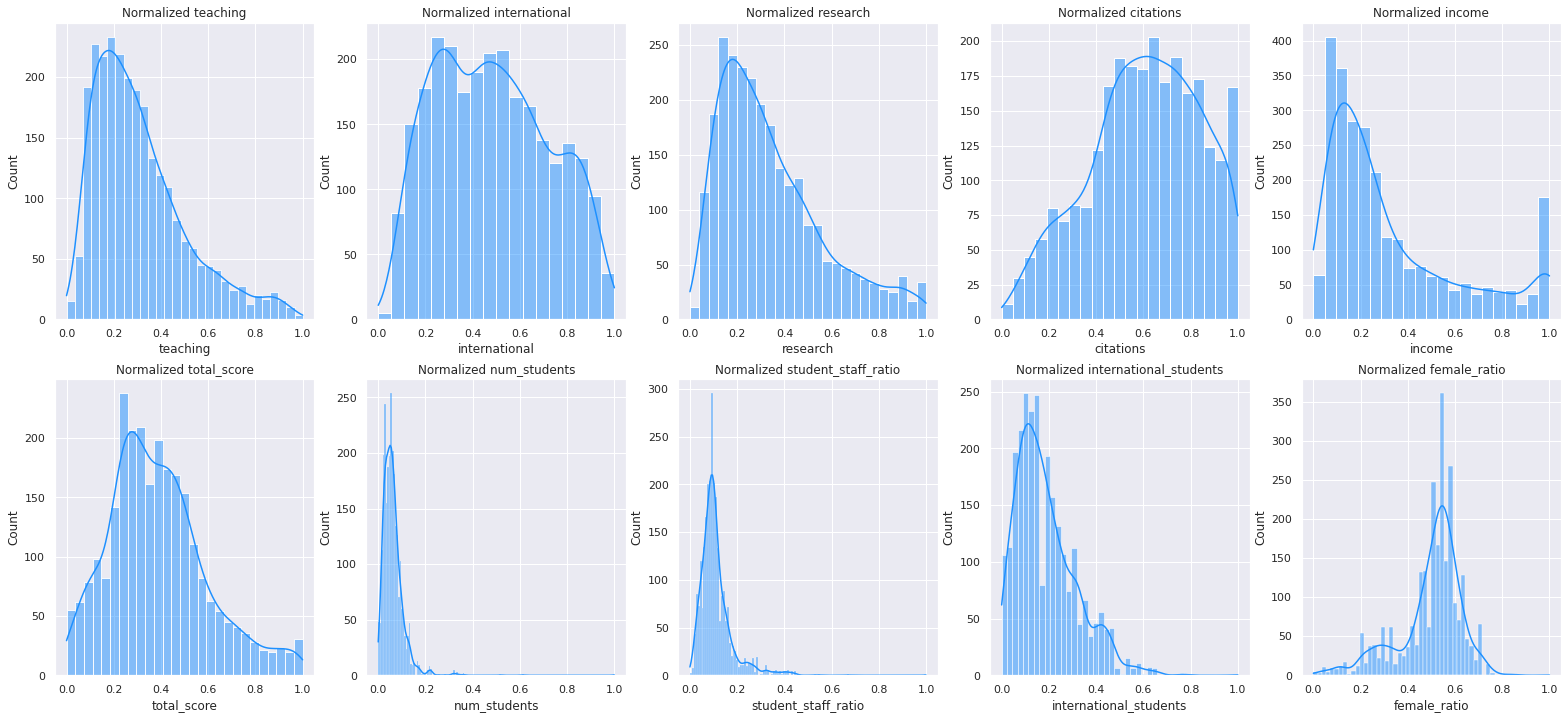

In [ ]:
# Histograms for numerical variables
fig, axes = plt.subplots(2, 5, figsize=(27, 12))
axes = axes.ravel() 

for id in range(len(numerical_vars)):
  col = numerical_vars[id]
  sns.histplot(data, x=col, color="dodgerblue", kde=True, ax=axes[id])
  axes[id].set_title("Normalized "+col)

### Statistical Hypothesis Testing

**Research Problem Statement** : *Is the average percentage of international students in UK universities higher than that in the US?*

> ***Null hypothesis***<br>There is no difference between the average percentage of US and UK university students who are of international origin over the years.<br><br>***Alternative hypothesis***<br>The average percentage of UK university students who are of international origin over the years, is higher than in the US.



**Mathematical Representation:**


> $x :$ Set of UK international_students<br>$y :$ Set of US international_students<br><br>$H_o : \mu_x = \mu_y$<br>$H_1 : \mu_x > \mu_y$



**Graphical Depiction**

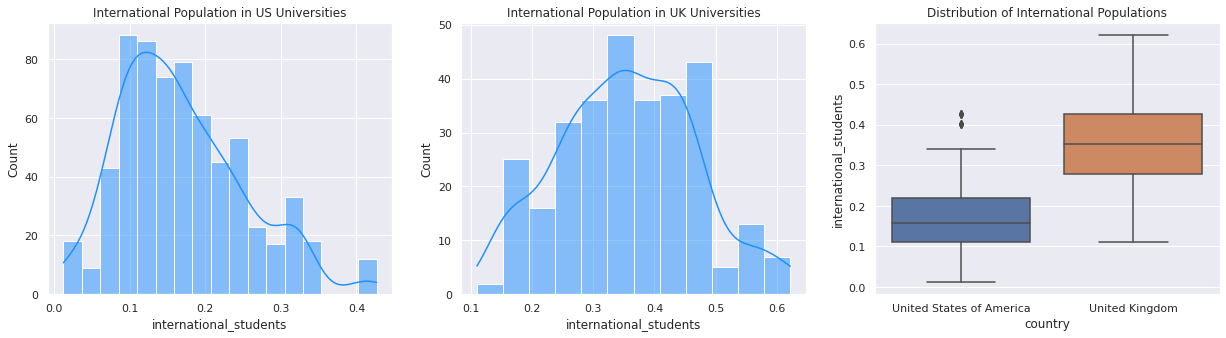

In [ ]:
dataUS = data.loc[data['country'] == 'United States of America']
dataUK = data.loc[data['country'] == 'United Kingdom']

interUS = dataUS['international_students']
interUK = dataUK['international_students']

fig, axes = plt.subplots(1, 3, figsize=(21, 5))
axes = axes.ravel() 

sns.histplot(data, x=interUS, color="dodgerblue", kde=True, ax=axes[0])
ax0 = axes[0].set_title("International Population in US Universities")
sns.histplot(data, x=interUK, color="dodgerblue", kde=True, ax=axes[1])
ax1 = axes[1].set_title("International Population in UK Universities")
sns.boxplot(data=data.loc[data.country.isin(['United States of America', 'United Kingdom'])],
           x='country',
           y='international_students',
           ax=axes[2])
ax1 = axes[2].set_title("Distribution of International Populations")

**Measuring statistical significance of the observed results using the Welch t-test**

The samples here are the measured observations of international_students of the countries US and UK. They are drawn independently and the means, variances and sample sizes are calculated below.

In [ ]:
# Set the statistical significance (alpha) for the test
alpha = 0.005

In [ ]:
# Calculate the length of each feature vector
sizeUS = len(interUS)
sizeUK = len(interUK)

# Observe that sample sizes are different
print('Sample sizes: US = {}, UK = {}'.format(sizeUS, sizeUK))

Sample sizes: US = 659, UK = 300


In [ ]:
# Calculate means of both samples
meanUS = interUS.mean()
meanUK = interUK.mean()

# Calculate variance of both samples
varUS = interUS.var()
varUK = interUK.var()

# Observe that the variances are unequal
print('Sample means: US = {}, UK = {}'.format(meanUS, meanUK))
print('Sample variance: US = {}, UK = {}'.format(varUS, varUK))

Sample means: US = 0.16743772900551437, UK = 0.3550813008130085
Sample variance: US = 0.006994389532519845, UK = 0.012567629092148647


The sample sizes are different. These are unequal samples and therefore cannot be subjected to the Student's t-test. The Student's t-test assumes sample sizes and variances to be equal and here, this is not the case.

Since both sample sizes are large (> 30), the means are both approximately
normally distributed. The samples are independent, and therefore the null
distribution of the difference of the means follows a normal distribution.

The condition for normal distribution is satisfied and we decide to use the Welsh t-test, which performs better when sample sizes and variances are unequal.

The t-score is calculated using, <br><br>
$t_{score} = \frac {\bar {X}_1 - \bar {X}_2} {s_{Welch}}$<br><br>where $\bar {X}_1 - \bar {X}_2$ is the difference of sample means, and, <br><br>
$s_{Welch}  = \sqrt{\frac{s^2_1} {n_1}+\frac{s^2_2} {n_2}}$

In [ ]:
# Find the p value from Welch t-test
t_score = stats.ttest_ind_from_stats(interUS.mean(), interUS.std(), interUS.shape[0],
                                   interUK.mean(), interUK.std(), interUK.shape[0],
                                   equal_var=False)

# one-sided p value is half of the returned two-sided p value
p_value = t_score.pvalue / 2
print(t_score.statistic, p_value)

-25.89585812291491 6.279645983215036e-92


In [ ]:
# Either reject or fail to reject the null hypothesis using p value 
if p_value < alpha:
  print('Null hypothesis has enough evidence to be rejected.\n Null hypothesis rejected.')
else:
  print('Null hypothesis does not have enough evidence to be rejected.\n Failed to reject null hypothesis.')

Null hypothesis has enough evidence to be rejected.
 Null hypothesis rejected.


$ p < 0.005 $

Since our p value was far lesser than the statistical significance value, we can reliably reject the null hypothesis, in favour of the alternative.

Additionally, we obtained a negative t-test statistic score, which implies that the mean of international students in UK universities is greater than in US universities.

We reject $H_o : \mu_x = \mu_y$  , where<br><br>$x :$Set of UK international_students<br>$y :$ Set of US international_students

### Correlation

In [ ]:
# Table for the pair-wise correlation of features x and y
corr_data = pg.pairwise_corr(data,columns=numerical_vars)
corr_data

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,teaching,international,pearson,two-sided,2603,0.139012,"[0.1, 0.18]",0.019324,0.018570,0.139918,1.051986e-12,2.529e+09,1.000000
1,teaching,research,pearson,two-sided,2603,0.913120,"[0.91, 0.92]",0.833788,0.833660,1.545980,0.000000e+00,inf,1.000000
2,teaching,citations,pearson,two-sided,2603,0.503867,"[0.47, 0.53]",0.253882,0.253308,0.554475,1.196685e-167,4.751e+163,1.000000
3,teaching,income,pearson,two-sided,2603,0.323557,"[0.29, 0.36]",0.104689,0.104000,0.335615,1.678531e-64,6.315e+60,1.000000
4,teaching,total_score,pearson,two-sided,2603,0.889349,"[0.88, 0.9]",0.790941,0.790781,1.418802,0.000000e+00,inf,1.000000
5,teaching,num_students,pearson,two-sided,2603,0.042748,"[0.0, 0.08]",0.001827,0.001060,0.042775,2.918652e-02,0.265,0.587659
6,teaching,student_staff_ratio,pearson,two-sided,2603,-0.280054,"[-0.32, -0.24]",0.078430,0.077721,-0.287740,4.113496e-48,3.061e+44,1.000000
7,teaching,international_students,pearson,two-sided,2603,0.276878,"[0.24, 0.31]",0.076661,0.075951,0.284298,5.035295e-47,2.534e+43,1.000000
8,teaching,female_ratio,pearson,two-sided,2603,-0.157360,"[-0.19, -0.12]",0.024762,0.024012,-0.158678,6.751277e-16,3.476e+12,1.000000
9,international,research,pearson,two-sided,2603,0.250956,"[0.21, 0.29]",0.062979,0.062258,0.256433,1.127706e-38,1.265e+35,1.000000


**Analyze the correlation between `teaching` and `total_score`**

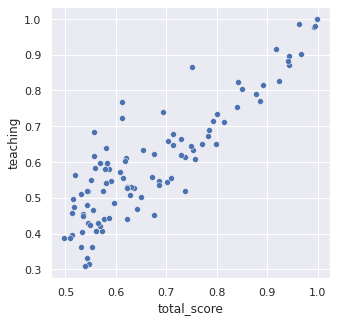

In [ ]:
# Plot a scatter plot between teaching and total_score
top2011 = data.loc[data['year'] == 2011].head(100)

x = top2011['total_score']
y = top2011['teaching']

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=x, 
                   y=y)

Hence, we can conclude that universities with greater overall score have better teaching scores. The relation follows a roughly linear path with positive slope.


*This suggests a positive correlation between the variables.*

We can infer that universities that are ranked higher up have better learning and educational environments.

**Analyze the correlation between `research` and `citations` in 2015 and 2016**

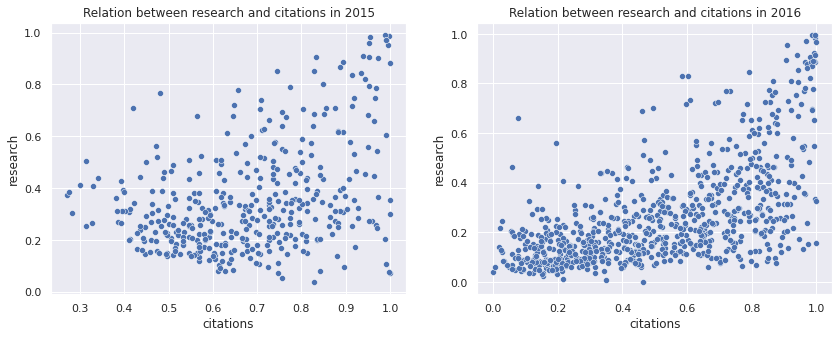

In [ ]:
# Select data from 2015 and 2016
data2015 = data.loc[data['year'] == 2015]
data2016 = data.loc[data['year'] == 2016]

# Pick out citations and research score data
x_2015 = data2015['citations']
y_2015 = data2015['research']
x_2016 = data2016['citations']
y_2016 = data2016['research']

# Plot scatterplots for both years
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("Relation between research and citations in 2015")
ax = sns.scatterplot(x = x_2015, 
                   y = y_2015)
plt.subplot(1, 2, 2)
plt.title("Relation between research and citations in 2016")
ax = sns.scatterplot(x = x_2016, 
                   y = y_2016)
plt.show()

We can infer from the plotted graphs that the research score approximately follows an exponential curve, indicating that a higher `citation` score (how much a university is contributing to the sum of human knowledge), the higher the `research` score (a university’s reputation for research excellence among its peers). 

*This suggests a positive correlation between the variables.*

This does have exceptions however, where universities with a high `citation` score in the lower right part of the plots had a very low `research` score. A couple universities with very low `citation` scores had relatively high `research`scores.

**Analyze the correlation between `student_staff_ratio` and `teaching`**

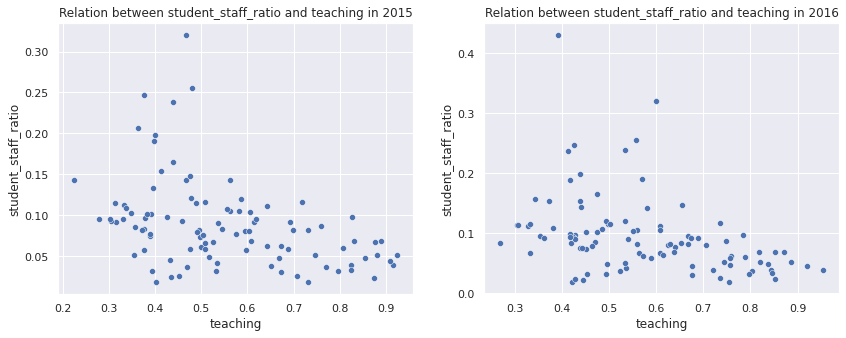

In [ ]:
# Plot a scatter plot between student_staff_ratio and international_students
top2015 = data.loc[data['year'] == 2015].head(100)
top2016 = data.loc[data['year'] == 2016].head(100)

x_2015 = top2015['teaching']
y_2015 = top2015['student_staff_ratio']

x_2016 = top2016['teaching']
y_2016 = top2016['student_staff_ratio']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("Relation between student_staff_ratio and teaching in 2015")
ax = sns.scatterplot(x = x_2015, 
                   y = y_2015)
plt.subplot(1, 2, 2)
plt.title("Relation between student_staff_ratio and teaching in 2016")
ax = sns.scatterplot(x = x_2016, 
                   y = y_2016)
plt.show()

We can infer from this graph that teaching scores and student_staff_ratio are negatively correlated. Universities with higher teaching scores and relatively better learning environments have relatively lesser staff employed.

### Resources Used

The Pitfalls of Data Normalization : 
https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/pitfalls-of-data-normalization-bf05d65f1f4c

How low can a p-value go? : https://stats.stackexchange.com/questions/11812/sanity-check-how-low-can-a-p-value-go

Welch t - testing Notes : https://ocw.mit.edu/resources/res-6-009-how-to-process-analyze-and-visualize-data-january-iap-2012/lectures-and-labs/MITRES_6_009IAP12_lab3a.pdf